In [1]:
#import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#load data
# file = 'chirps_full_WA.nc'
# data = xr.open_dataset(file)
data = xr.open_dataset('chirps_full_WA.nc')
WA_data = data['precip'].where(data['precip']!=-99)

In [3]:
WA_data

<xarray.DataArray 'precip' (time: 10958, latitude: 84, longitude: 80)>
array([[[       nan,        nan,        nan, ..., 0.09513035,
         0.18271613, 0.        ],
        [       nan,        nan,        nan, ..., 0.7660875 ,
         0.54629076, 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.01122632, 0.0770435 , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ..., 0.6227504 ,
         2.5817764 , 2.1820595 ],
        [       nan,        nan,        nan, ..., 0.        ,
         2.0366068 , 2.8003762 ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.18811882, 1.1806384 ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.        ,
         0.        , 0.        ],
        [       nan,        nan,        nan, ..., 0.4054568 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2020-12-31
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
  * longitude  (longitude) float32 -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0

In [4]:
#extracting data for part of the 4 Bioclimatic zones
SBZ= WA_data.sel(latitude=slice(16,20),longitude=slice(-18,18))
Sahel= WA_data.sel(latitude=slice(12,16),longitude=slice(-18,18))
Sudano= WA_data.sel(latitude=slice(8,12),longitude=slice(-18,18))
GBZ = WA_data.sel(latitude=slice(4,8),longitude=slice(-18,18))


# Sudano

In [5]:
#Grouping the data by the Jullian day 
doy_SBZ = SBZ.mean(['longitude','latitude']).groupby('time.dayofyear')
doy_Sahel = Sahel.mean(['longitude','latitude']).groupby('time.dayofyear')
doy_Sudano = Sudano.mean(['longitude','latitude']).groupby('time.dayofyear')
doy_GBZ = GBZ.mean(['longitude','latitude']).groupby('time.dayofyear')
doy_WA = WA_data.mean(['longitude','latitude']).groupby('time.dayofyear')



In [6]:
# doy_SBZ[60]

In [7]:
# doy_Sahel[60]

In [8]:
#Function for Anomaly Computation & Data Check for inf values
def ano(x,dim):
    return (x-x.mean(dim=dim))

def inf_check(p, grid=True):
    if grid==True:
        p = p.where(p!=np.inf).where(p!=-np.inf)
    else:
        p[np.isinf(p)==True] = np.nan
    return p

In [9]:
# data_zones = [doy_SBZ, doy_Sahel, doy_Sudano,doy_GBZ,doy_WA]


In [10]:
# SBZ

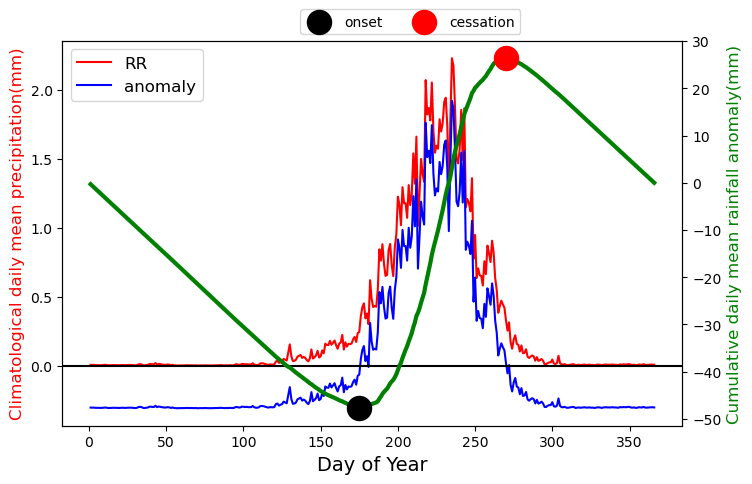

In [18]:
x = list(doy_SBZ.groups.copy())
fig, ax = plt.subplots(figsize=(8,5))

avg_data = inf_check(doy_SBZ.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
ax.legend(loc='upper left', fontsize=12)
ax.set_ylabel('Climatological daily mean precipitation(mm)', color='r', fontsize=12 )
# # ax.set_ylabel('Climatological daily mean precipitation anomaly(mm/day)', color='b', ha ='left', fontsize=12)

ax.set_xlabel('Day of Year', fontsize=14)


ax.axhline(y=0, color='k')   #horizontal black line at the zero mark


ax1 = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
ax1.plot(x, anom, color='g', linewidth=3)
ax1.set_ylabel('Cumulative daily mean rainfall anomaly(mm)', fontsize=12, color='g')     #set labe
            

#Onset and Cessation Detection                 
anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    
            
ax1.scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
ax1.scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))      
fig.savefig('West_Africa')
                

In [12]:
# for d, ax in zip(data_zones,axes.flatten()):
#     print(d)


In [13]:
# count = 0
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30,26))#, sharex = True, sharey=True)
# fig.suptitle('Onset and Cessation for Each Year', fontsize=20)
# fig.text(0, 0.5, 'Climatological daily mean precipitation (mm)', va='center', rotation='vertical',fontsize=20, color='r')
# fig.text(1, 0.5, 'Cumulative daily mean rainfall anomaly(mm)', va='center', rotation='vertical', fontsize=20, color='g')
# fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=20)
# plt.subplots_adjust(wspace=0.5, hspace=1)


# for d, ax in zip(data_zones,axes.flatten()):
# #     ax = axes[count // 5, count % 5]  # Access the appropriate subplot based on count

#     zone = d[0]  #Extract the year from the data
#     d1 = d[1].groupby('time.dayofyear').sum('time')
#     x = d1.dayofyear
#     #x = list(doy_data91.groups.copy())

#     avg_data = inf_check(d1, grid=True)
#     avg_data.plot(ax=ax, color='r')#, label='RR')
#     ano(avg_data, dim="dayofyear").plot(ax=ax, color='b')#, label='anomaly')

#     # Legend
#     ax.legend(loc='upper left', fontsize=12)
#     #     ax.set_ylabel('Climatological daily mean precipitation(mm)', color='r', fontsize=12)
#     #     ax.set_xlabel('Day of Year', fontsize=14)
#     ax.axhline(y=0, color='k')  # Horizontal black line at the zero mark

#     ax1 = ax.twinx()
#     anom = ano(avg_data, dim='dayofyear').cumsum()
#     ax1.plot(x, anom, color='g', linewidth=3)
#     #     ax1.set_ylabel('Cumulative daily mean rainfall anomaly(mm)', fontsize=12, color='g')  # Set label

#     # Onset and Cessation Detection
#     anomaly = anom.values
#     dx = 28  # Detection window (we use a nearly monthly interval to avoid multiple mid-month false onset)
#     onset = []
#     cessation = []
#     for i in range(dx, len(anomaly) - dx):
#         if np.min(anomaly[i - dx:i + dx]) == anomaly[i]:
#             onset.append([i + 1, anomaly[i + 1]])
#         if np.max(anomaly[i - dx:i + dx]) == anomaly[i]:
#             cessation.append([i + 1, anomaly[i + 1]])

#     ax1.scatter(np.copy(onset).T[0], np.copy(onset).T[1], 300, color='k', zorder=5)
#     ax1.scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5) #label='cessation')
#     ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))

#     count += 1
# # filterwarnings('ignore')    

# plt.show

In [14]:
# x = [
#     x_SBZ = list(doy_SBZ.groups.copy())
#     x_Sahel = list(doy_Sahel.groups.copy())
#     x_Sud = list(doy_Sudano.groups.copy())
#     x_GBZ = list(doy_GBZ.groups.copy())
#     x_WA = list(doy_WA.groups.copy())
    

In [15]:
# count = 0
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 26))
# fig.suptitle('Onset and Cessation for Each Year', fontsize=20)
# fig.text(0, 0.5, 'Climatological daily mean precipitation (mm)', va='center', rotation='vertical', fontsize=20, color='r')
# fig.text(1, 0.5, 'Cumulative daily mean rainfall anomaly(mm)', va='center', rotation='vertical', fontsize=20, color='g')
# fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=20)
# plt.subplots_adjust(wspace=0.5, hspace=1)

# data_zones = [
#     ('SBZ', SBZ.mean(['longitude', 'latitude'])),
#     ('Sahel', Sahel.mean(['longitude', 'latitude'])),
#     ('Sudano', Sudano.mean(['longitude', 'latitude'])),
#     ('GBZ', GBZ.mean(['longitude', 'latitude'])),
#     ('WA', WA_data.mean(['longitude', 'latitude']))
# ]

# for zone, data in data_zones:
#     ax = axes[count]  # Access the appropriate subplot based on count

#     d1 = data.groupby('time.dayofyear')#.sum('time')
#     x = d1.time.dayofyear

#     avg_data = inf_check(d1, grid=True)
#     avg_data.plot(ax=ax, color='r')
#     ano(avg_data, dim="dayofyear").plot(ax=ax, color='b')

#     ax.legend(loc='upper left', fontsize=12)
#     ax.axhline(y=0, color='k')

#     ax1 = ax.twinx()
#     anom = ano(avg_data, dim='dayofyear').cumsum()
#     ax1.plot(x, anom, color='g', linewidth=3)

#     anomaly = anom.values
#     dx = 28
#     onset = []
#     cessation = []
#     for i in range(dx, len(anomaly) - dx):
#         if np.min(anomaly[i - dx:i + dx]) == anomaly[i]:
#             onset.append([i + 1, anomaly[i + 1]])
#         if np.max(anomaly[i - dx:i + dx]) == anomaly[i]:
#             cessation.append([i + 1, anomaly[i + 1]])

#     ax1.scatter(np.copy(onset).T[0], np.copy(onset).T[1], 300, color='k', zorder=5)
#     ax1.scatter(np.copy(cessation).T[0], np.copy(cessation).T[1], 300, color='r', zorder=5)
#     ax1.legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))

#     count += 1

# plt.show()


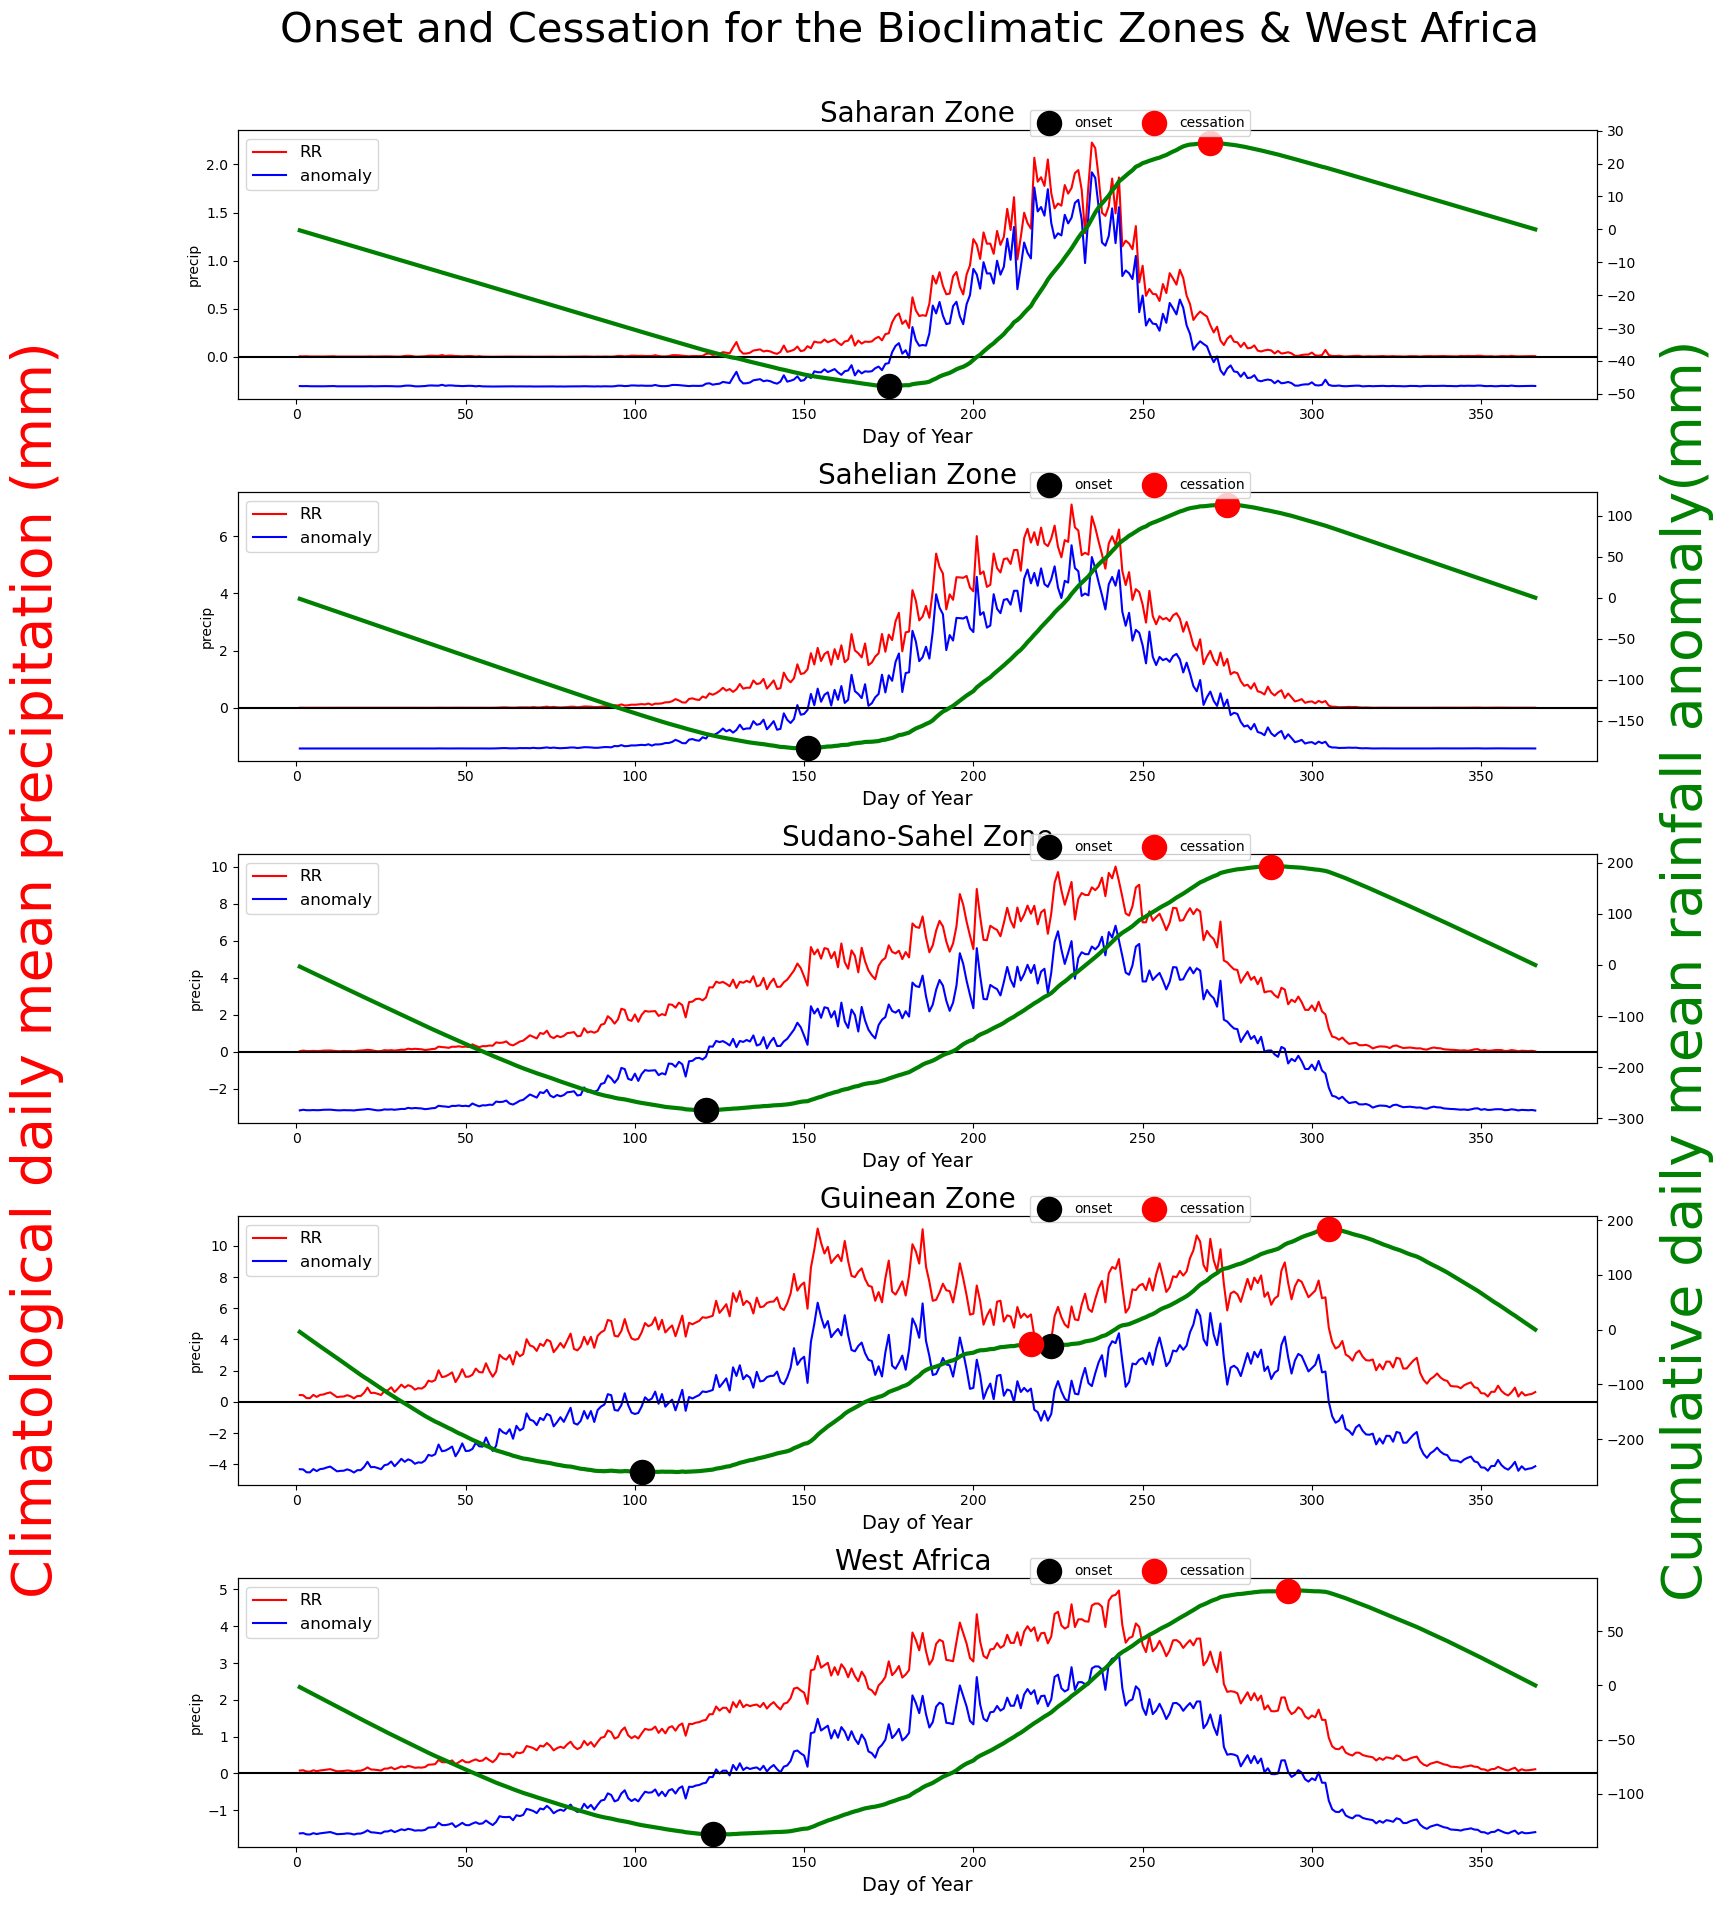

In [19]:
x_SBZ = list(doy_SBZ.groups.copy())
x_Sahel = list(doy_Sahel.groups.copy())
x_Sud = list(doy_Sudano.groups.copy())
x_GBZ = list(doy_GBZ.groups.copy())
x_WA = list(doy_WA.groups.copy())

fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(15,20))

fig.suptitle('Onset and Cessation for the Bioclimatic Zones & West Africa', fontsize=30)
fig.text(-0.1, 0.5, 'Climatological daily mean precipitation (mm)', va='center', rotation='vertical',fontsize=40, color='r')
fig.text(1, 0.5, 'Cumulative daily mean rainfall anomaly(mm)', va='center', rotation='vertical', fontsize=40, color='g')
# fig.text(0.5, 0.04, 'Day of Year', ha='center', fontsize=20)
plt.subplots_adjust(hspace=1)

# 1st subplot
ax=axes[0]
avg_data = inf_check(doy_SBZ.mean(),grid=True)
avg_data.plot(ax = axes[0],color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
axes[0].legend(loc='upper left', fontsize=12)

axes[0].set_xlabel('Day of Year', fontsize=14)


axes[0].axhline(y=0, color='k')   #horizontal black line at the zero mark
axes[0] = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
axes[0].plot(x_SBZ, anom, color='g', linewidth=3)
# axes[0].set_ylabel('Cumulative daily mean rainfall anomaly(mm)', fontsize=12, color='g')     #set labe

#Onset and Cessation Detection
# axes[0]
anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    

axes[0].scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
axes[0].scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
axes[0].legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))   
axes[0].set_title('Saharan Zone', fontsize=20)

# 2nd subplot
ax=axes[1]
avg_data = inf_check(doy_Sahel.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
axes[1].legend(loc='upper left', fontsize=12)

axes[1].set_xlabel('Day of Year', fontsize=14)


axes[1].axhline(y=0, color='k')   #horizontal black line at the zero mark
axes[1] = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
axes[1].plot(x_Sahel, anom, color='g', linewidth=3)

anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    

axes[1].scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
axes[1].scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
axes[1].legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))
axes[1].set_title('Sahelian Zone', fontsize=20)

# 3rd subplot
ax=axes[2]
avg_data = inf_check(doy_Sudano.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
axes[2].legend(loc='upper left', fontsize=12)

axes[2].set_xlabel('Day of Year', fontsize=14)


axes[2].axhline(y=0, color='k')   #horizontal black line at the zero mark
axes[2] = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
axes[2].plot(x_Sud, anom, color='g', linewidth=3)

anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    

axes[2].scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
axes[2].scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
axes[2].legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))
axes[2].set_title('Sudano-Sahel Zone', fontsize=20)


# 4th subplot
ax=axes[3]
avg_data = inf_check(doy_GBZ.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
axes[3].legend(loc='upper left', fontsize=12)

axes[3].set_xlabel('Day of Year', fontsize=14)


axes[3].axhline(y=0, color='k')   #horizontal black line at the zero mark
axes[3] = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
axes[3].plot(x_GBZ, anom, color='g', linewidth=3)

anomaly = anom.values
dx = 12 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    

axes[3].scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
axes[3].scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
axes[3].legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))
axes[3].set_title('Guinean Zone', fontsize=20)


# 5th subplot
ax=axes[4]
avg_data = inf_check(doy_WA.mean(),grid=True)
avg_data.plot(ax = ax,color='r',label='RR')
ano(avg_data,dim='dayofyear').plot(ax = ax, color='b', label='anomaly')

# legend
axes[4].legend(loc='upper left', fontsize=12)

axes[4].set_xlabel('Day of Year', fontsize=14)


axes[4].axhline(y=0, color='k')   #horizontal black line at the zero mark
axes[4] = ax.twinx()
anom = ano(avg_data, dim='dayofyear').cumsum()
axes[4].plot(x_WA, anom, color='g', linewidth=3)

anomaly = anom.values
dx = 28 #Detection window (we use a nearly monthly interval to avoid multiple mind-month false onset)                
onset = []; cessation=[]
for i in range(dx,len(anomaly)-dx):
    if np.min(anomaly[i-dx:i+dx]) == anomaly[i]:
        onset.append([i+1,anomaly[i+1]])
    if np.max(anomaly[i-dx:i+dx]) == anomaly[i]:
       cessation.append([i+1, anomaly[i+1]])    

axes[4].scatter(np.copy(onset).T[0],np.copy(onset).T[1], 300, color='k', zorder=5, label='onset')              
axes[4].scatter(np.copy(cessation).T[0],np.copy(cessation).T[1], 300, color='r', zorder=5, label='cessation')
axes[4].legend(loc=1, ncol=2, bbox_to_anchor=(0.75, 1.1))
axes[4].set_title('West Africa ', fontsize=20)

plt.show
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig('Bioclimatic_zones')

In [17]:
onset[0]

[123, -137.6127]